In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from importlib import reload

import correlation as corr
from speckle_stat import SpeckleStatistics
from speckle_stat import Pk

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# 0) Prelude: speckle probability

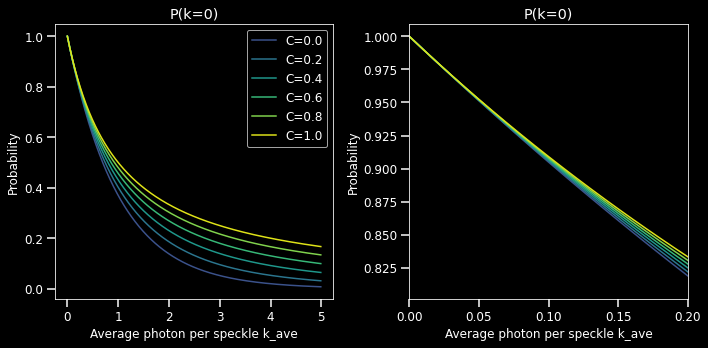

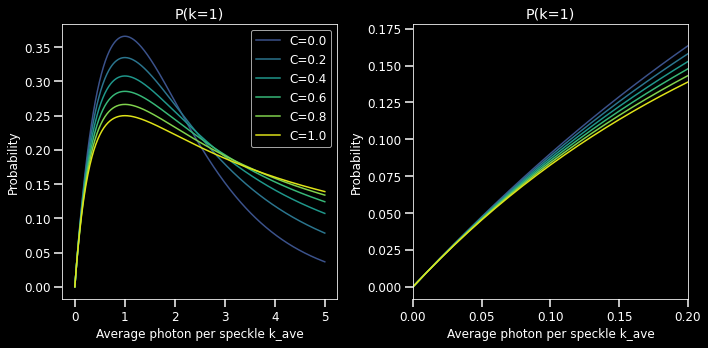

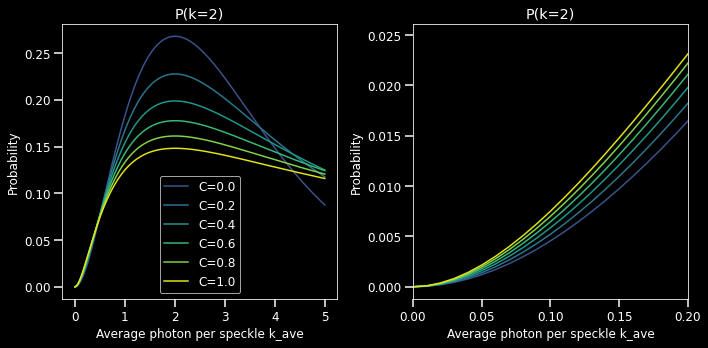

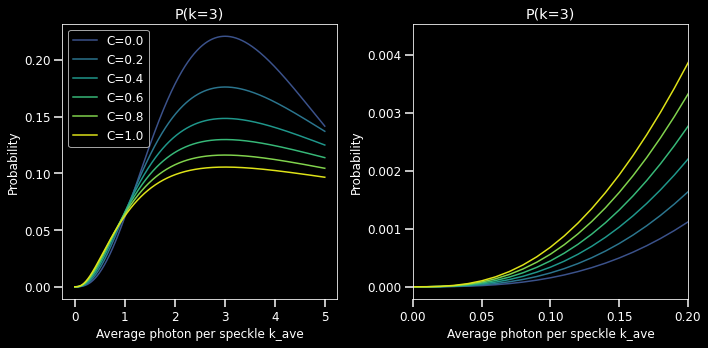

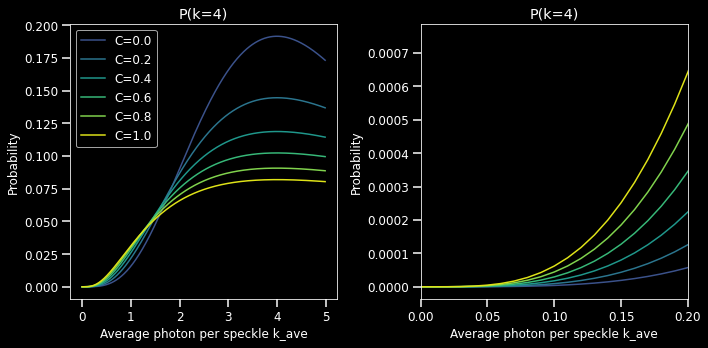

In [3]:

kave = np.arange(0,5,0.01)
Cs = np.array([0.01,0.2,0.4,0.6,0.8,1])
Ms = 1/Cs
colors = plt.cm.viridis(np.linspace(0.25,0.95,Cs.size))

for k in range(5):
    k=k
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    for ii, M in enumerate(Ms):
        P = Pk(k,kave,M)
        ax[0].plot(kave,P, label='C={:.1f}'.format(Cs[ii]), color=colors[ii])
        ax[0].set_title('P(k='+str(k)+')')
        ax[0].set_xlabel('Average photon per speckle k_ave')
        ax[0].set_ylabel('Probability')
#         ax[0].legend(loc='lower right')
        ax[0].legend()
        
        ax[1].plot(kave[:22],P[:22], color=colors[ii])
        ax[1].set_xlim(0,0.2)
        ax[1].set_title('P(k='+str(k)+')')
        ax[1].set_xlabel('Average photon per speckle k_ave')
        ax[1].set_ylabel('Probability')
    plt.tight_layout()
plt.show()

# 1) Autocorrelation

Example with Jungfrau average detector image from in-house beamtime xpp40718.

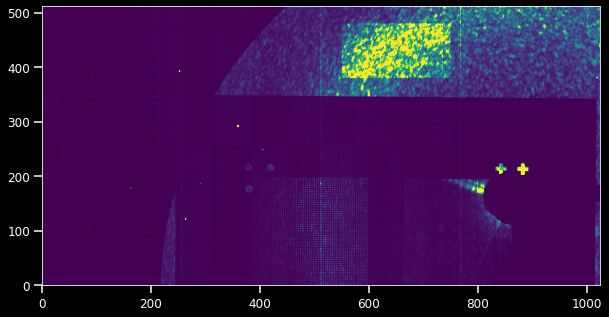

In [4]:
run = 36
dat = np.load('./data_examples/proba_r{}.npz'.format(run))
pk = dat['pk']
kbar = dat['kbar']
Nroi = dat['Nroi']
aimg = dat['aimg']

roi = [380,480, 550,750]
img = aimg[0]
mask = np.zeros_like(img).astype(bool)
mask[roi[0]:roi[1], roi[2]:roi[3]] = True
plt.imshow(img*(1+1.5*mask), clim=(0,8), origin='lower')
plt.show()

## Correct for non-uniform illumination

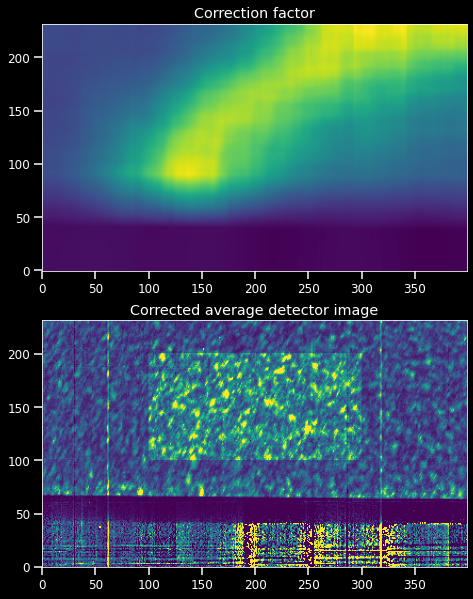

In [5]:
img_corr, mask2, bp = corr.correct_illumination(img, mask, kernel_size=50)

fig, ax = plt.subplots(nrows=2, figsize=(14,10))
ax[0].set_title('Correction factor')
ax[0].imshow(bp, origin='lower')
ax[1].set_title('Corrected average detector image')
ax[1].imshow(img_corr[0]*(1+mask2), clim=(0,10), origin='lower')
plt.show()

## Compute and fit autocorrelation

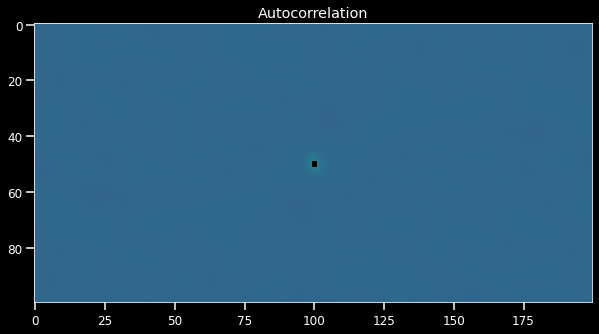

In [6]:
A = corr.spatial_correlation_fourier(img_corr[0], mask=mask2)
A = corr.remove_central_corr(A)

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(A, clim=(0.5,2))
ax.set_title("Autocorrelation")
plt.show()

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 97
    # variables        = 4
    chi-square         = 5.7275e-04
    reduced chi-square = 6.1586e-06
    Akaike info crit   = -1159.85763
    Bayesian info crit = -1149.55879
[[Variables]]
    amplitude:  1.01487142 +/- 0.00936963 (0.92%) (init = 1)
    center:     49.0000000 +/- 0.02178594 (0.04%) (init = 49)
    sigma:      2.23711190 +/- 0.02442581 (1.09%) (init = 1)
    c:          0.99891533 +/- 2.6766e-04 (0.03%) (init = 1)
    fwhm:       5.26799584 +/- 0.05751838 (1.09%) == '2.3548200*sigma'
    height:     0.18098117 +/- 0.00194097 (1.07%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.444
    C(amplitude, c)     = -0.330
    C(sigma, c)         = -0.208


[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    #

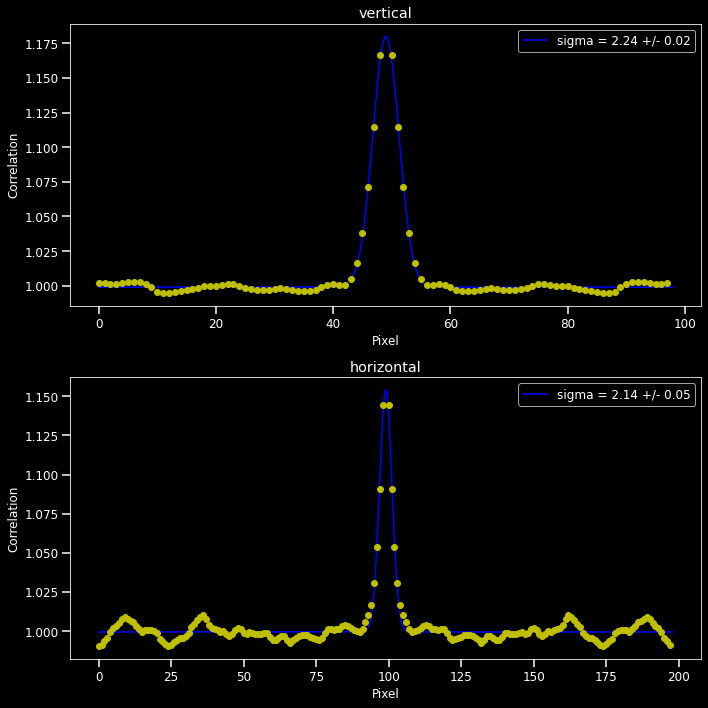

In [7]:
corr.fit_correlation(A)

# 2) Contrast fit

Example with the data from the epix100, under a pixel mask.

What needs to be saved from the image processing for the contrast extraction:
- kave
- photon probabilities (at least k=0-3)
- size of the ROI

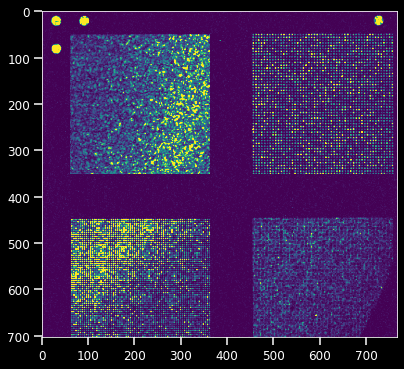

In [8]:
run = 91
dat = np.load('./data_examples/proba_r{}.npz'.format(run))
pk = dat['pk']
kbar = dat['kbar']
Nroi = dat['Nroi']
aimg = dat['aimg']

plt.imshow(aimg, clim=(0,8))
plt.show()

In [9]:
speck = SpeckleStatistics(kbar, pk, nRoi=Nroi, kavgRange=[0.01,0.4,15])

## Fit binomial distribution

0.6949400193046227 +/- 0.004673829733616642
0.6669667362700282 +/- 0.0060038662114186726
0.719211061122553 +/- 0.006670981829190924


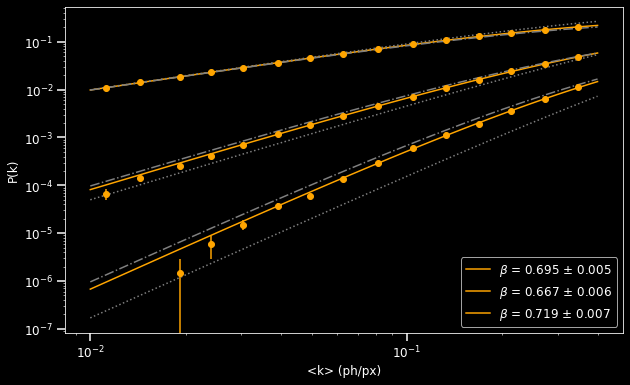

In [10]:
fig, ax = plt.subplots()
# beta, beta_err, fitRes = speck.fit_pk(0, ax=ax)
# print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(1, ax=ax)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(2, ax=ax)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(3, ax=ax)
print('{} +/- {}'.format(beta, beta_err))

### Without kavg binning

0.6792803128821688 +/- 0.0036293117822294224
0.6541081074877985 +/- 0.0071621780014470325


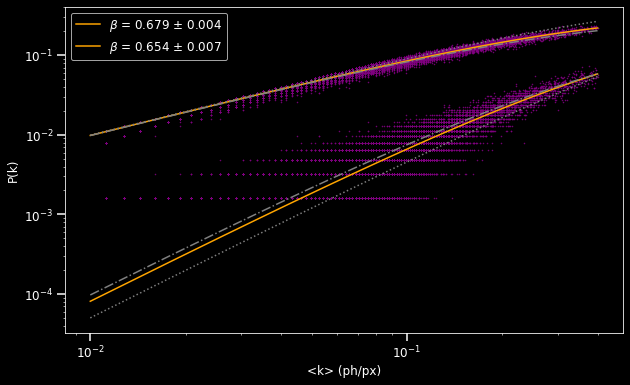

In [11]:
fig, ax = plt.subplots()

beta, beta_err, fitRes = speck.fit_pk(1, ax=ax, bin_kavg=False)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(2, ax=ax, bin_kavg=False)
print('{} +/- {}'.format(beta, beta_err))
# beta, beta_err, fitRes = speck.fit_pk(3, ax=ax, bin_kavg=False)
# print('{} +/- {}'.format(beta, beta_err))

## Maximum likelihood estimate

/reg/neh/home4/espov/python/XPCS/xpcs/speckle_stat.py:70: RuntimeWarning: divide by zero encountered in true_divide
  chi_sq = np.asarray([-2*np.nansum( prob*nRoi*np.log(Pk(k,kavg,M)/prob) ) for M in Ms])
/reg/neh/home4/espov/python/XPCS/xpcs/speckle_stat.py:70: RuntimeWarning: invalid value encountered in multiply
  chi_sq = np.asarray([-2*np.nansum( prob*nRoi*np.log(Pk(k,kavg,M)/prob) ) for M in Ms])


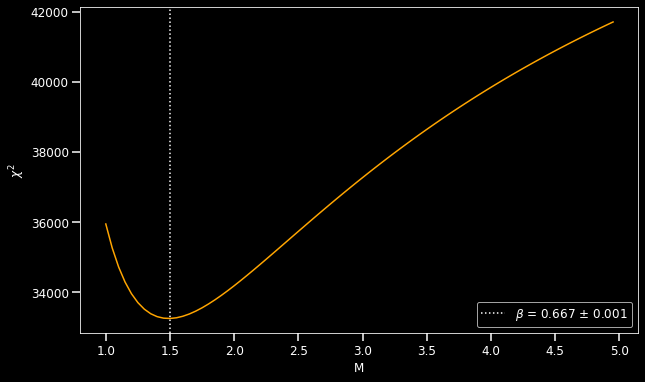

In [12]:
fig, ax = plt.subplots()
beta, beta_err, M, MLE = speck.MLE_contrast(M=np.arange(1,5,0.05), ax=ax)

## More examples on lower contrast

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11-py3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11-py3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11-py3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11-py3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11-py3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid v

0.2851099940068045 +/- 0.01985578689963214
0.28687596112896463 +/- 0.02881380012469099
0.25099015801578645 +/- 0.029613234494834224


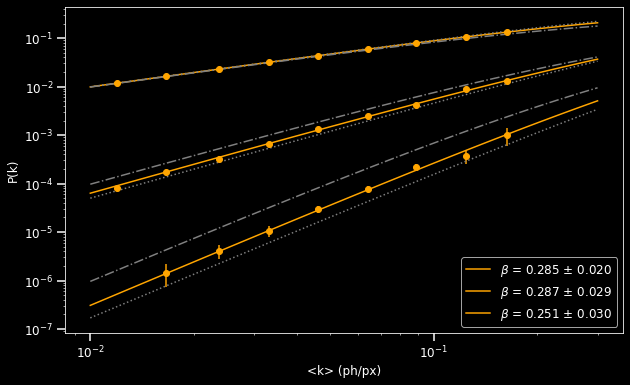

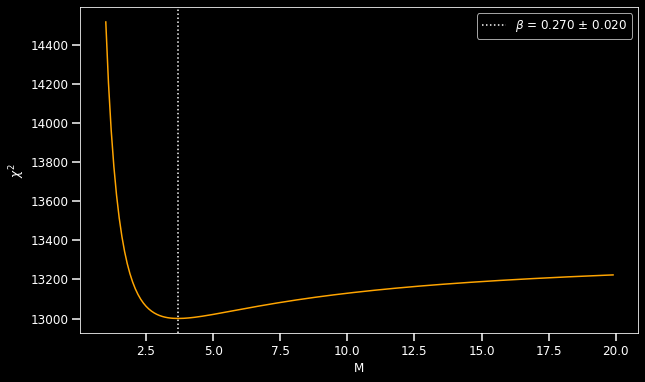

In [13]:
run = 125
dat = np.load('./data_examples/proba_r{}.npz'.format(run))
pk = dat['pk']
kbar = dat['kbar']
Nroi = dat['Nroi']
aimg = dat['aimg']

# plt.imshow(aimg, clim=(0,8))
# plt.show()

# FIT
speck = SpeckleStatistics(kbar, pk, nRoi=Nroi)
fig, ax = plt.subplots()
beta, beta_err, fitRes = speck.fit_pk(1, ax=ax)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(2, ax=ax)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(3, ax=ax)
print('{} +/- {}'.format(beta, beta_err))

# MLE
fig, ax = plt.subplots()
beta, beta_err, M, MLE = speck.MLE_contrast(ax=ax)

0.10651696988450972 +/- 0.008416277044524901
0.10449083472012875 +/- 0.006358196776998613
0.1071280934511916 +/- 0.020698726853022174


/reg/neh/home4/espov/python/XPCS/xpcs/speckle_stat.py:70: RuntimeWarning: divide by zero encountered in true_divide
  chi_sq = np.asarray([-2*np.nansum( prob*nRoi*np.log(Pk(k,kavg,M)/prob) ) for M in Ms])
/reg/neh/home4/espov/python/XPCS/xpcs/speckle_stat.py:70: RuntimeWarning: invalid value encountered in multiply
  chi_sq = np.asarray([-2*np.nansum( prob*nRoi*np.log(Pk(k,kavg,M)/prob) ) for M in Ms])


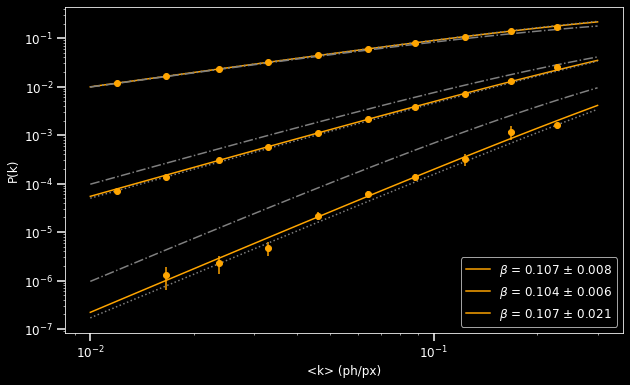

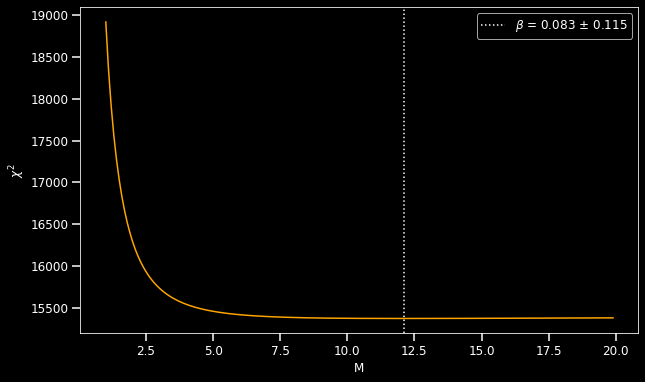

In [14]:
run = 136
dat = np.load('./data_examples/proba_r{}.npz'.format(run))
pk = dat['pk']
kbar = dat['kbar']
Nroi = dat['Nroi']
aimg = dat['aimg']

# plt.imshow(aimg, clim=(0,8))
# plt.show()

# FIT
speck = SpeckleStatistics(kbar, pk, nRoi=Nroi)
fig, ax = plt.subplots()
beta, beta_err, fitRes = speck.fit_pk(1, ax=ax)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(2, ax=ax)
print('{} +/- {}'.format(beta, beta_err))
beta, beta_err, fitRes = speck.fit_pk(3, ax=ax)
print('{} +/- {}'.format(beta, beta_err))

# MLE
fig, ax = plt.subplots()
beta, beta_err, M, MLE = speck.MLE_contrast(ax=ax)

In [1]:
pwd

'/cds/home/e/espov/python/XPCS/xpcs'